In [1]:
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000, delta_e_cie1976
from dredFISH.Analysis.TissueGraph import *
from dredFISH.Visualization.Viz import *
import matplotlib.pyplot as plt 
from scipy.spatial.distance import *

from scipy.optimize import minimize
from scipy.optimize import Bounds
from sklearn.manifold import MDS

In [2]:
TMG = TissueMultiGraph('/home/rwollman/MixedSupervizedAndUnsupervized.pkl')
XY = TMG.Layers[0].XY

In [130]:
def color_diff(clr1,clr2, mode = "RGB",de = "1976"): 
    """
    clr1/2 are 3 elements only
    """
    if mode=="RGB": 
        clr1_rgb = sRGBColor(clr1[0],clr1[1],clr1[2]);
        clr2_rgb = sRGBColor(clr2[0],clr2[1],clr2[2]);

        # Convert from RGB to Lab Color Space
        clr1_lab = convert_color(clr1_rgb, LabColor);

        # Convert from RGB to Lab Color Space
        clr2_lab = convert_color(clr2_rgb, LabColor);
    
    # Find the color difference
    if de == "2000":
        delta_e = delta_e_cie2000(clr1_lab, clr2_lab);
    elif de == "1976": 
        delta_e = delta_e_cie1976(clr1_lab, clr2_lab);
    else: 
        raise ValueError("de must be 1976 or 2000 (strings)")
    
    return delta_e

def color_diff_vec(clr1,clr2,mode = "RGB",de = "1976"): 
    """
    clr1/2 are numpy array nx3
    """
    if mode =="Lab" and de == "1976": 
        delta_e = np.sqrt(np.sum(np.power(clr1 - clr2, 2), axis=1))
    elif mode=="RGB": 
        delta_e = np.zeros((clr1.shape[0],1))

        # convert to colormath objects
        for i in range(clr1.shape[0]):
            # Find the color difference
            delta_e[i] = color_diff(clr1[i,:],clr2[i,:],mode="RGB")
    
    return delta_e

Dtype = pdist(TMG.Layers[1].feature_type_mat,metric = 'correlation')
Dtype_org = Dtype.copy()
Dtype = np.log(Dtype)
Dtype = Dtype/Dtype.sum()
EL = TMG.Layers[0].SG.get_edgelist()
EL = np.array(EL)
NeighboringTypes,NT_weight = np.unique(TMG.Layers[0].Type[EL],return_counts=True,axis=0)
ix = np.flatnonzero(NeighboringTypes[:,0]==NeighboringTypes[:,1])
NT_weight[ix]=0
NT_weight = NT_weight/NT_weight.sum()

def scoreColor(clr,mode = "Lab",opt = {}):
    
    sz = int(len(clr)/3)
    clr = np.reshape(clr,(sz,3))
    if mode=="RGB":
        Dclr = pdist(clr, color_diff)
    else: 
        clr[:,0] = clr[:,0]*100
        clr[:,1] = (clr[:,1]-0.5)*256
        clr[:,2] = (clr[:,2]-0.5)*256
        Dclr = pdist(clr,'euclidean')
    
    clr_L = clr[NeighboringTypes[:,0],:]
    clr_R = clr[NeighboringTypes[:,1],:]
    
    neigh_dE = np.sum(color_diff_vec(clr_L,clr_R,mode=mode)*NT_weight)
    
    # scr = (Dclr.min()+neigh_dE) * np.corrcoef(Dclr,Dtype)[0,1]
    # scr = ((Dclr*Dtype).sum()+neigh_dE) * np.corrcoef(Dclr,Dtype)[0,1]
    # scr = np.sum(Dclr*Dtype)+neigh_dE 
    scr = np.sum(Dclr*Dtype)+neigh_dE + Dclr.mean()* np.corrcoef(Dclr,Dtype_org)[0,1]
    
    return(scr)

def convert_lab01_2rgb(clr_best):
    sz = int(len(clr_best)/3)
    clr_best = np.reshape(clr_best,(sz,3))
    clr_rgb = np.zeros(clr_best.shape)
    for i in range(clr_rgb.shape[0]):
        clr_lab = LabColor(clr_best[i,0]*100,(clr_best[i,1]-0.5)*255,(clr_best[i,2]-0.5)*255)
        clr_rgb[i,:] = np.array(convert_color(clr_lab,sRGBColor).get_value_tuple())

    clr_rgb = np.clip(clr_rgb,0,1)
    return clr_rgb

def rand_clr_step(clr,scl = 0.05, mode = "Lab"):
    # convet to n x 3 matrix
    sz = int(len(clr)/3)
    clr = np.reshape(clr,(sz,3))
    
    # random a step
    dc = (np.random.rand(sz,3)-0.5)*scl
    
    # step 
    clr = clr+dc
    
    # clamp
    mn=(0,0,0)
    mx=(1,1,1)
    for i in range(3):
        clr[:,i]=np.clip(clr[:,i],mn[i],mx[i])
        
    return(clr)


def clr_mds(Dtype):
    embedding = MDS(n_components=3,dissimilarity='precomputed')
    clr_start = embedding.fit_transform(squareform(Dtype))
    clr_start = clr_start -clr_start.min(axis=0)
    clr_start = clr_start/clr_start.max(axis=0)
    return clr_start


i: 0 Found better scheme, scr: 206.02


Text(0.5, 1.0, '206.01779987333765')

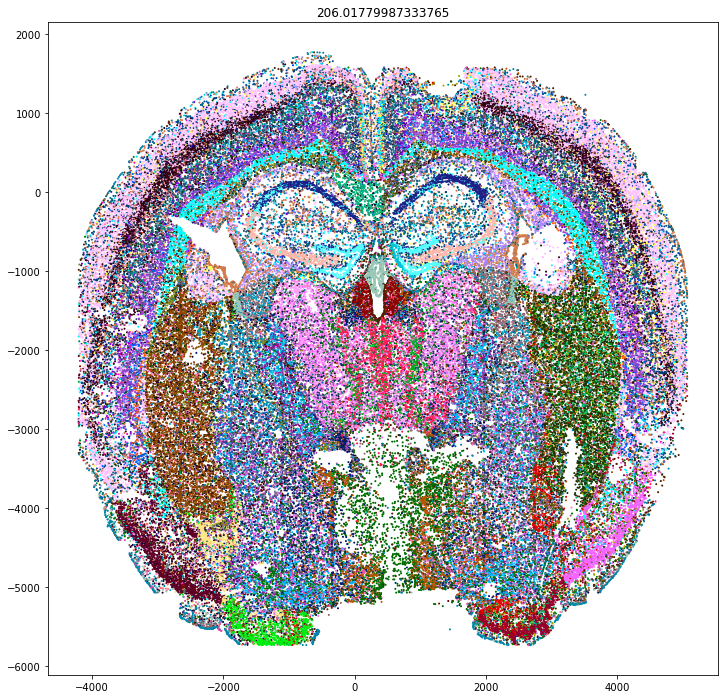

In [131]:
scr_best=0; 
clr_best = np.zeros((TMG.Ntypes[1],3))

iter=1
for i in range(iter):
    clr_start = clr_mds(Dtype)

    scr = scoreColor(clr_start.flatten(),mode="Lab")
    if scr>scr_best:
        clr_best = clr_start
        scr_best = scr
        print(f"i: {i} Found better scheme, scr: {scr:.2f}")
        
clr_rgb = convert_lab01_2rgb(clr_best.flatten())        
plt.figure(figsize=(12,12))
plt.scatter(x=XY[:,0],y=XY[:,1],c=TMG.Layers[0].Type,s=1,cmap= ListedColormap(clr_rgb))
plt.title(scr_best)

Text(0.5, 1.0, '340.8641555962238')

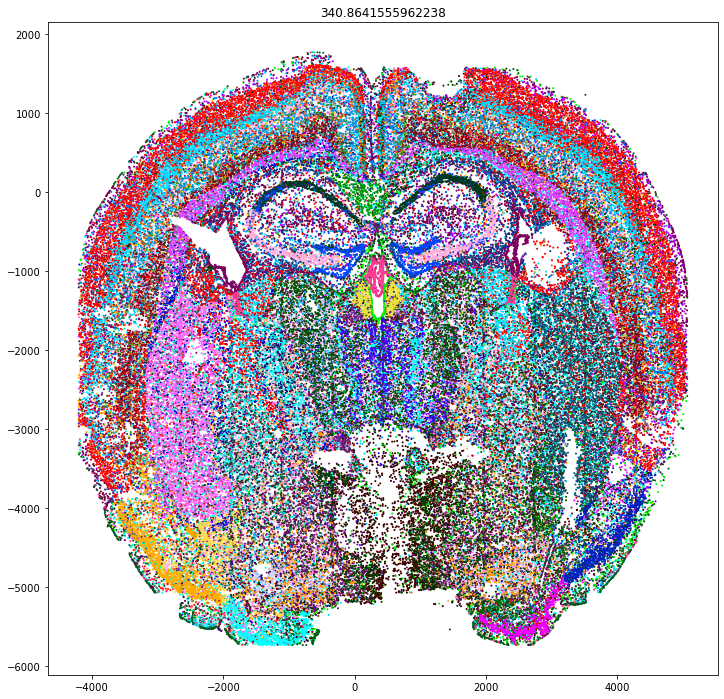

In [141]:
iter=1000

clr = clr_best
rand_accept_rate=0
scl=0.05
scr_lst = list()

# MCMC-MH
for i in range(iter):
    # take a random small step
    clr = rand_clr_step(clr.flatten(),scl=scl)
    scr = scoreColor(clr.flatten(),mode="Lab")

    if scr>scr_best or np.random.rand(1)<rand_accept_rate:
        clr_best = clr
        scr_best = scr
        scr_lst.append((i,scr))

clr_rgb = convert_lab01_2rgb(clr_best.flatten())          

plt.figure(figsize=(12,12))
plt.scatter(x=XY[:,0],y=XY[:,1],c=TMG.Layers[0].Type,s=1,cmap= ListedColormap(clr_rgb))
plt.title(scr_best)

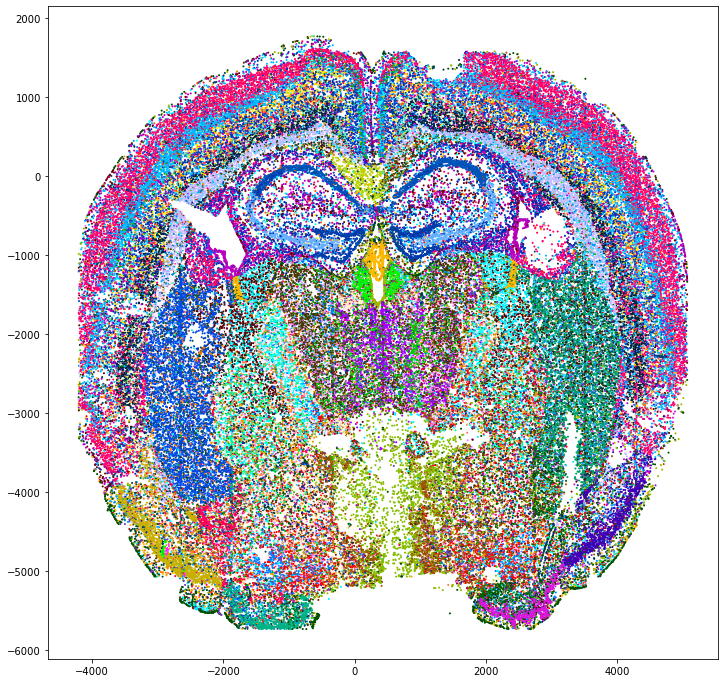

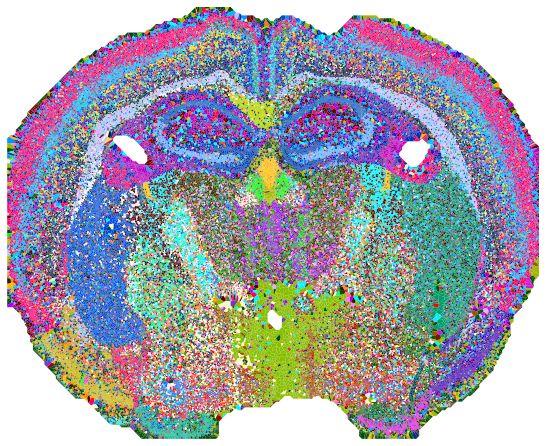

In [136]:
plt.figure(figsize=(12,12))
plt.scatter(x=XY[:,0],y=XY[:,1],c=TMG.Layers[0].Type,s=1,cmap= ListedColormap(clr_rgb))
V = View(TMG, name = "Opt Color")
V.figsize = (10,6)
CP = Colorpleth(TMG.Layers[0].Type)
CP.clrmp = ListedColormap(clr_rgb)
V.add_panel(CP)
V.show()